# Detection of Relevant Object in Construction Site Pictures

This notebook demos [Amazon Rekognition Custom Labels](https://aws.amazon.com/rekognition/)' ability to learn how to detect relevant objects from pictures, using a dataset copied from [Context-based information generation from construction site images using unmanned aerial vehicle (UAV)-acquired data and image captioning](https://data.mendeley.com/datasets/4h68fmktwh/1). The dataset is licensed as [CC BY 4.0](http://creativecommons.org/licenses/by/4.0).

The notebook consists of the following steps:

1. Download and decompress the dataset
2. Load all image metadata and generate classes for each bounding box:
    1. Process the manifest file provided, consisting of the format explained on the [README](https://github.com/bobbruno/aws-rekognition-cl-demo) in the repository;
    2. Run the bounding boxes' descriptive phrases through [Amazon Comprehend](https://aws.amazon.com/comprehend/), to identify the syntactic elements.
    3. Extract the relevant elements from the description and process them (filtering irrelevant words/typos, lowercase, eliminating plurals) to be suitable object classes.
3. Split the data into training and test.
4. Generate an [Object Detection Ground Truth Manifest file](https://docs.aws.amazon.com/rekognition/latest/customlabels-dg/cd-required-fields.html) describing the dataset, which is required by Rekognition Custom Labels.
5. Create a Rekognition Project and Start the model (project version) training.
6. Deploy a model and run an inference against it.
7. Stop the model.

Steps 1 and 2 are done and should be separated, and the processed dataset saved for iterating over steps 4-7.

## Initial Setup/Configuration

In [26]:
import json
from PIL import Image as Imagem
import boto3
from pprint import pprint
from sklearn.model_selection import train_test_split

s3 = boto3.client("s3")
bucket = "sagemaker-us-east-1-113147044314"
input_path = "cl-demo/input"
reko_manifest_path = "cl-demo/reko-input"
output_path = "cl-demo/output"

In [50]:
comprehend = boto3.client(service_name='comprehend', region_name='us-east-1')
reko = boto3.client("rekognition")

## 1. Dowload/Decompress the dataset

The dataset is actually stored in S3, so we just use the boto3 S3 interface to download it.

In [ ]:
s3.download_file("md-datasets-cache-zipfiles-prod", "4h68fmktwh-1.zip", "data/construction.zip")

In [ ]:
!unzip data/construction.zip -d data
!unzip data/image_with_captions.zip -d data
!rm data/construction.zip

## 2. Generating Classifications from the Annotations

### Helper Classes for Processing the original manifest and generating object classifications

In [2]:
class BoundingBox(object):
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    def __repr__(self):
        return str(self.__dict__)
    
class Token(object):
    def __init__(self, TokenId, Text, BeginOffset, EndOffset, Tag, Score):
        assert Score > 0.9, 'Not enough confidence on tag'
        self.TokenId = TokenId
        self.Text = Text
        self.LowerText = Text.lower()
        self.BeginOffset = BeginOffset
        self.EndOffset = EndOffset
        self.Tag = Tag
        self.Score = Score
    def __repr__(self):
        return str(self.__dict__)

        
class ImageAnnotation(object):
    COLORS = {'blue', 'red', 'yellow', 'green', 'white', 'silver', 'gray', 'grey', 'orange', 'black', 'brown', 'pink', 'purple', 'while'}
    STOPWORDS = {'elevens', 'fivr', 'plie', 'thirteens', 'pile', 'piles'}
    
    def __init__(self, index, bounding_box, phrase, comprehend=None):
        self.bb = bounding_box
        self.index = index
        self.phrase = phrase
        if (comprehend):
            self.update_tokens(comprehend)
        else:
            self.Tokens = None
            self.obj_class = None
        
    def _gen_tokens(self, comprehend):
        return(comprehend.detect_syntax(LanguageCode='en', Text=self.phrase)['SyntaxTokens'])
    
    def update_tokens(self, comprehend):
        self.Tokens = self._gen_tokens(comprehend) if len(self.phrase) else None
        if self.Tokens and len(self.Tokens):
            self.obj_class = self.get_class()
        else:
            self.obj_class = None
        
    def get_class(self):
        assert self.Tokens, "No tokenization available for class extraction"
        def get_object(tokens):
            noun_part = []
            for token in tokens:
                if token['PartOfSpeech']['Tag'] == 'VERB':
                    break
                if token['Text'].lower() in ImageAnnotation.COLORS:
                    continue
                if token['Text'].lower() in ImageAnnotation.STOPWORDS:
                    continue
                if token['PartOfSpeech']['Tag'] in ('ADJ', 'NOUN', 'PROPN'):
                    noun_part.append(token)
            return ' '.join([x['Text'] for x in noun_part])
        result = get_object(self.Tokens)
        if len(result) > 0:
            result = result[:-1] if result[-1] == 's' else result
        return(result)
        
    def __repr__(self):
        return str(self.__dict__)


class Image(object):
    def __init__(self, path, filename, size, annotations):
        self.path = path
        self.filename = filename
        self.size = size
        self.annotations = annotations
        im = Imagem.open(f"{self.path}/{self.filename}")
        self.width, self.height = im.size
        self.classify_image()
        
    def classify_image(self):
        self.obj_classes = {annotation.obj_class for annotation in self.annotations if annotation.obj_class}
    
    def gen_tokens(self, comprehend):
        for annot in self.annotations:
            annot.update_tokens(comprehend)
            
    def __repr__(self):
        return str(self.__dict__)


### Helper Function to process the manifest

In [3]:
def load_images(path, manifest_file, comprehend=None):
    with open(manifest_file, "r") as source_manifest:
        manifest = json.load(source_manifest)
    images = []
    for _, image in manifest.items():
        try:
            try:
                annotations = []
                for (index, annotation) in image['regions'].items():
                    shape_attrs = annotation['shape_attributes']
                    shape_attrs.pop('name')
                    phrase = annotation['region_attributes']['phrase']
                    img = ImageAnnotation(index, BoundingBox(**shape_attrs), phrase, comprehend)
                    if img.obj_class and len(img.obj_class):
                        annotations.append(img)
            except:
                pprint(annotation['shape_attributes'])
                raise
            images.append(
                Image(path, image['filename'], image['size'], annotations)
            )
        except:
            pprint(image)
            raise
    return(images)

In [4]:
image_objs = load_images("data/UAVdata", "data/via_region_data_final.json", comprehend)
[image.classify_image() for image in image_objs]

## 3. Train/Test Split

I have used a [scikit-learn](https://scikit-learn.org/stable/) helper function to split the data. In practice, it just shuffles the original array and splits according to pct_train (which is a percentage of total data if between 0 and 1 and an absolute number of examples if larger than 1).

The split also sets aside images without any annotation, since they are no use for either training or testing.

In [12]:
def split_data(image_objs, pct_train=0.5, random_state=None):
    classified_images = [image for image in image_objs if len(image.obj_classes) > 0]
    unclassified_images = [image for image in image_objs if len(image.obj_classes) == 0]
    train_images, test_images = train_test_split(classified_images, train_size=pct_train, random_state=random_state)
    return(train_images, test_images, unclassified_images)

In [246]:
train_data, test_data, unclassified = split_data(image_objs, pct_train=120)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [247]:
len(train_data)

120

## Preparing the Ground Truth Manifest

Rekognition expects to receive a manifest file in a very specific format, which is the output format for [SageMaker Ground Truth](https://docs.aws.amazon.com/sagemaker/latest/dg/data-prep.html). The specifics of this format can be found [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-data-output.html#sms-output-box).

### Generate a mapping of the most common classes to ids (required by the manifest format)

In [256]:
from collections import Counter

class_map = {classif: i+1 for (i, (classif, _)) in
             enumerate(
                 Counter(
                     [an.obj_class for image in train_data for an in image.annotations if an.obj_class and len(an.obj_class)]
                 ).most_common(34)
             )}

In [257]:
def gen_manifest(image, class_map, s3_path, job_number=0, max_annotations=None, indent=None):
    img_annotations = image.annotations if max_annotations is None else image.annotations[:max_annotations]
    class_map['others'] = 0

    classes_in_img = {an.obj_class for an in img_annotations}
    if len(classes_in_img.difference(class_map.keys())):
        classes_in_img.add('others')
    annotations = [{
        "class_id": class_map.get(an.obj_class, 0),
        "left": an.bb.x,
        "top": an.bb.y,
        "width": an.bb.width,
        "height": an.bb.height
    } for an in img_annotations]
    
    manifest = {
        "source-ref": f'{s3_path}/{image.filename}',
        "bounding-box": { 
            "image_size": [
                {
                    "width": image.width,
                    "height": image.height,
                    "depth": 3 
                }
            ],
            "annotations": annotations
        },
        "bounding-box-metadata": { 
            "objects": [ {"confidence": 0.9} for _ in img_annotations ],
            "class-map": {v: k for k, v in class_map.items() if k in classes_in_img},
            "type": "groundtruth/object-detection",
            "human-annotated": "yes",
            "creation-date": "2020-02-25T22:50:05.0000z",
            "job-name": f"identify-construction-objs-{job_number}"
        }
     }
    return(json.dumps(manifest, indent=indent))

def save_manifest(data, path):
    s3_path = f"s3://{bucket}/{input_path}"
    with open(path, 'w') as outfile:
        for example in data:
            outfile.write(f"{gen_manifest(example, class_map, s3_path, max_annotations=5)}\n")

In [273]:
manifest_ext = "120_v2"

In [274]:
save_manifest(train_data, f'data/train_{manifest_ext}.manifest')
save_manifest(test_data[:120], f'data/test_{manifest_ext}.manifest')

### Validating Manifest File

In [131]:
class Schemas:
    """
    Schema Definitions
    """

    SOURCE_SCHEMA = {
        "type": "object",
        "required": [
            "source-ref"
        ],
        "properties": {
            "source-ref": {
                "description": "Image S3 image URL",
                "type": "string",
                "pattern": "^s3://([^/]+)/(.*)$"
            }
        },
        "additionalProperties": False,
        'maxItems': 1,
        'minItems': 1
    }

    ATTRIBUTE_SCHEMA = {
        "definitions": {
            "image_size": {
                "type": "array",
                "items": {
                    "type": "object",
                    "required": [
                        "width",
                        "height",
                        "depth"
                    ],
                    "properties": {
                        "width": {
                            "$ref": "#/definitions/image_dimension"
                        },
                        "height": {
                            "$ref": "#/definitions/image_dimension"
                        },
                        "depth": {
                            "type": "number",
                            "min": 1,
                            "max": 3
                        }
                    }
                }
            },
            "annotations": {
                "type": "array",
                "items": {
                    "type": "object",
                    "required": [
                        "width",
                        "height",
                        "top",
                        "left",
                        "class_id"
                    ],
                    "properties": {
                        "width": {
                            "type": "number"
                        },
                        "height": {
                            "type": "number"
                        },
                        "top": {
                            "type": "number"
                        },
                        "left": {
                            "type": "number"
                        },
                        "class_id": {
                            "type": "integer"
                        }
                    }
                }
            },
            "image_dimension": {
                "type": "number",
                "minimum": 64,
                "maximum": 4096
            },
            "confidence": {
                "type": "number",
                "minimum": 0.0,
                "maximum": 1.0
            },
            "objects": {
                "type": "array",
                "items": {
                    "type": "object",
                    "required": [
                        "confidence"
                    ],
                    "properties": {
                        "confidence": {
                            "$ref": "#/definitions/confidence"
                        }
                    }
                }
            }
        },
        "patternProperties": {
            "^[A-Za-z0-9-]+": {
                "oneOf": [
                    {
                        "type": "object",
                        "description": "Detection label data",
                        "properties": {
                            "annotations": {
                                "$ref": "#/definitions/annotations"
                            },
                            "image_size": {
                                "$ref": "#/definitions/image_size"
                            }
                        },
                        "required": [
                            "annotations",
                            "image_size"
                        ]
                    },
                    {
                        "description": "Classification label data",
                        "type": ["integer", "string"]
                    }
                ]
            }
        },
        'minItems': 1
    }

    METADATA_SCHEMA = {
        "definitions": {
            "confidence": {
                "type": "number",
                "minimum": 0.0,
                "maximum": 1.0
            },
            "class-map": {
                "type": "object",
                "propertyNames": {"pattern": "^[0-9]+"},
                "patternProperties": {"": {"type": "string", "minLength": 1, "maxLength": 256}}
            },
            "objects": {
                "type": "array",
                "items": {
                    "type": "object",
                    "required": [
                        "confidence"
                    ],
                    "properties": {
                        "confidence": {
                            "$ref": "#/definitions/confidence"
                        }
                    }
                }
            }
        },
        "patternProperties": {
            "^[A-Za-z0-9-]+": {
                "description": "Ground Truth label metadata",
                "properties": {
                    "class-map": {
                        "$ref": "#/definitions/class-map"
                    },
                    "human-annotated": {
                        "type": "string",
                        "enum": ["yes", "no"]
                    },
                    "type": {
                        "type": "string",
                        "enum": ["groundtruth/image-classification", "groundtruth/object-detection"]
                    },
                    "creation-date": {
                        "type": "string",
                        "format": "date-time"
                    },
                    "confidence": {
                        "$ref": "#/definitions/confidence"
                    },
                    "class-name": {
                        "type": "string",
                        "minLength": 1,
                        "maxLength": 256
                    },
                    "objects": {
                        "$ref": "#/definitions/objects"
                    }
                },
                "required": [
                    "human-annotated",
                    "type",
                    "creation-date"
                ],
                "oneOf": [
                    {
                        "required": [
                            "confidence",
                            "class-name"
                        ]
                    },
                    {
                        "required": [
                            "class-map",
                            "objects"
                        ]
                    }
                ]
            }
        },
        'minItems': 5
    }

AUTO_ML_SERVICE_INPUT_BUCKET = "rekognition-automl-training"
AUTO_ML_SERVICE_ARTIFACTS_BUCKET = "rekognition-automl-models"
AUTO_ML_MODEL_ZOO_ARTIFACTS_BUCKET = "rekognition-automl-modelzoo"

# Lambda input event constants
ACCOUNT_ID = "AccountId"
PROJECT_ID = "ProjectId"
VERSION_NAME = "VersionName"
PROJECT_VERSION_ARN = "ProjectVersionArn"
S3_PROJECT_PREFIX = "S3ProjectVersionPrefix"
HPO_JOB_NAME_OVERWRITE = "HPOJobName"
USE_CASE = "UseCase"
EXECUTION_START_TIME = "executionStartTime"

# Lambda input context constants
REGION = "region"
SERVICE_ACCOUNT_ID = "service_account_id"
VERSION = "version"

# GT manifest fields from API definition
DATASETS_KEY = "Datasets"
USE_TYPE_KEY = "UseType"
GT_MANIFEST_KEY = "GroundTruthManifest"
S3_OBJECT_KEY = "S3Object"
TRAIN_MANIFEST_TYPE = "TRAINING"
TEST_MANIFEST_TYPE = "TESTING"
OUTPUT_CONFIG_OWNER_ID_KEY = "OutputConfigOwnerId"
TRAIN_DATASET_OWNER_ID_KEY = "TrainDatasetOwnerId"
TEST_DATASET_OWNER_ID_KEY = "TestDatasetOwnerId"

# Sagemaker GT Augmented manifest constants
SOURCE_REF = "source-ref"
ORIGINAL_SOURCE = "original-source"
METADATA_SUFFIX = "metadata"
ATTRIBUTE_ANNOTATIONS = "annotations"
ATTRIBUTE_IMAGE_SIZE = "image_size"
ATTRIBUTE_IMAGE_WIDTH = "width"
ATTRIBUTE_IMAGE_HEIGHT = "height"
ATTRIBUTE_IMAGE_LEFT = "left"
ATTRIBUTE_IMAGE_TOP = "top"
METADATA_CLASS_MAP = "class-map"
METADATA_CLASS_NAME = "class-name"
METADATA_CLASS_ID = "class_id"
METADATA_OBJECTS = "objects"
METADATA_HUMAN_ANNOTATED = "human-annotated"
METADATA_CONFIDENCE = "confidence"
METADATA_JOB_NAME = "job-name"
METADATA_TYPE = "type"
METADATA_CREATION_DATE = "creation-date"
LABEL_TYPE_CLASSIFICATION = "image-classification"
LABEL_TYPE_DETECTION = "object-detection"
GROUND_TRUTH_TYPE_PREFIX = "groundtruth/"

# Intermediate SM training manifest constants
LABEL = "label"  # validated output attribute for SM training
ANNOTATION_TYPE = "annotation-type"  # use type for SM training
LINE_INDEX = "line-idx"  # line number from original manifest
IMAGE_RESIZE_RATIO = "resize-ratio"

# Output GT manifest constants
AUTOML_OBJECT_ID = "rekognition-custom-labels-object-id"
AUTOML_JOB_NAME = "rekognition-custom-labels-training-job"
AUTOML_LABEL = "rekognition-custom-labels-training"

# File constants
JSON_EXT = ".json"
CSV_EXT = ".csv"
UTF_8 = "utf-8"

# Manifest file
# Manifest format reference: https://quip-amazon.com/tkHTAzxM91P7/AutoML-Manifest-Format
TRAINING_MANIFEST = TRAIN_MANIFEST_TYPE + JSON_EXT
TESTING_MANIFEST = TEST_MANIFEST_TYPE + JSON_EXT
VALIDATED_GT_MANIFEST_SUFFIX = "_gt"  # validated GT-compatible manifest for customer
VALIDATED_MANIFEST_STATS_SUFFIX = '_stats'  # stats required for technique selection and evaluation
VALIDATED_MANIFEST_STATS_AFTER_FILTER_SUFFIX = '_stats_after_filter'  # stats after filter dataset
PRESPLIT_MANIFEST = "_presplit"  # original training manifest (before auto-split)
SM_MANIFEST = "SageMakerManifest"
GT_MANIFEST = "GroundTruthManifest"
VALID_SUFFIX = "_valid"  # suffix for manifest files after passing initial syntax and image validation checks
SPLIT_SUFFIX = "_split"  # suffix for manifest files after auto-split step. Does not imply if dataset was autosplit
MIN_DATASET_CLASSES = 2
MAX_DATASET_CLASSES = 250

# S3 constants
S3_PREFIX = "s3://"
CONTENT_LENGTH = "ContentLength"
CHUNK_SIZE_IN_BYTES = 200*1024*1024  # batch size for streaming s3 download
MIN_MULTIPART_UPLOAD_CHUNK_SIZE = 5*1024*1024  # 5MB
MAX_MULTIPART_UPLOAD_CHUNK_SIZE = 5*1024*1024*1024  # 5GB
MOCK_S3_BUCKET_OWNER_ID = '75aa57f09aa0c8caeab4f8c24e99d10f8e7faeebf76c078efc7c6caea54ba06a'  # This is fixed owner-id
# returned by mock_s3 used in unit tests.

# Validation constants
MAX_DATASET_OBJECTS = 250000
ONE_GB_IN_BYTES = 1*1024*1024*1024
MAX_MANIFEST_FILE_SIZE_IN_BYTES = ONE_GB_IN_BYTES
MAX_IMAGE_SIZE_IN_BYTES = 15*1024*1024  # 15MB
MAX_IMAGE_DIMENSION = 4096  # max supported image size
MIN_IMAGE_DIMENSION = 64  # min supported image size
RESIZE_IMAGE_DIMENSION = 1280  # image dimension re-size threshold
MAX_RESIZED_IMAGE_IN_BYTES = RESIZE_IMAGE_DIMENSION * RESIZE_IMAGE_DIMENSION * 3  # 1-byte per plane for RGB
S3_VERSION = "Version"
JPEG_QUALITY = 100

# Training data related constants
TEST_SPLIT_RATIO = 0.2
MIN_EXPECTED_NUM_CLASS_LABELS = 2
MAX_BBS_PER_IMAGE = 50
MAX_DATASET_ERROR_THRESHOLD_PERCENT = 20  # percent of invalid dataset objects/images which will cause job failure
PERCENT_100 = 100
MIN_TEST_TRAIN_OVERLAP_PERCENT = 50  # minimum overlap percent between test and train labels/classes
MIN_BB_DIMENSION = 1.0  # lines with BB width/height smaller than this will be skipped

# S3 Batch constants
BATCH_MANIFEST_FORMAT = "S3BatchOperations_CSV_20180820"
BATCH_REPORT_FORMAT = "Report_CSV_20180820"
BATCH_COPY_PREFIX = "/copy"  # output of batch copy
BATCH_VALIDATE_PREFIX = "/image_validation"  # output of image validation
BATCH_REPORT_PREFIX = "/report"
BATCH_REPORT_MANIFEST_JSON = "manifest.json"
BATCH_REPORT_JOB_PREFIX = "job"
TASK_SUCCEEDED = "succeeded"
TASK_FAILED = "failed"

# State machine result keys
BATCH_COPY_RESULT = "BatchCopyResult"
BATCH_COPY_JOBS = "BatchCopyJobIds"
IMAGE_VALIDATION_RESULT = "ImageValidationResult"
IMAGE_VALIDATION_JOBS = "ImageValidationJobIds"
INPUT_DATASET_SIZE = "DatasetSize"  # total input dataset size (includes invalid lines/images)
VALID_TRAINING_DATASET_SIZE = "ValidTrainingDatasetSize"  # valid images in training set
VALID_TESTING_DATASET_SIZE = "ValidTestingDatasetSize"  # valid images in testing set

# Image validation lambda task status
IMAGE_VALIDATION_PERMANENT_FAILURE = "PermanentFailure"
IMAGE_VALIDATION_SUCCESS = "Succeeded"

# Lambda constants
IMAGE_VALIDATION_FUNCTION = "ImageValidationFunction"

# Create Model Artifacts Constants
MODEL_GRAPH_DICTIONARY = "ModelGraphDictionary"
MODEL_ZOO_VERSION = "model_zoo_version"

# Model Zoo constants for techniques and use cases
MZOO_TECHNIQUE_FINETUNING = "FINETUNING"
MZOO_TECHNIQUE_MULTISTAGE = "MULTISTAGE"
MZOO_TECHNIQUE_INSTANCE_MATCH = "INSTANCEMATCH"
MZOO_USE_CASE_CLASSIFICATION = "CLASSIFICATION"
MZOO_USE_CASE_DETECTION = "DETECTION"

# Hardcode training instance type for now
TRAINING_INSTANCE_TYPE = "ml.p3.2xlarge"

# workflow execution output
WORKFLOW_OUTPUT = "WorkflowOutput"

# keys in workflow execution output
JOB_STATUS = "jobStatus"
CHILD_WORKFLOW_EXECUTION_STARTTIME = "childWorkflowExecutionStartTime"
WORKFLOW_NAME = "workflowName"

# StepFunction Job Status
JOB_STATUS_SUCCEED = "SUCCEED"
JOB_STATUS_CLIENT_ERROR = "CLIENT_ERROR"
JOB_STATUS_SERVICE_ERROR = "SERVICE_ERROR"

# Autosplit lambda response keys
IS_AUTOSPLIT_KEY = 'IS_AUTOSPLIT'

In [142]:
import logging
import jsonlines
from jsonlines.jsonlines import InvalidLineError
import fastjsonschema
#from datetime import datetime

#from rekognition_auto_ml_lambda.schemas.schema import Schemas
#from rekognition_auto_ml_lambda.utils.constants import SOURCE_REF, METADATA_SUFFIX, LABEL
#from rekognition_auto_ml_lambda.utils.constants import ATTRIBUTE_ANNOTATIONS, ATTRIBUTE_IMAGE_SIZE
#from rekognition_auto_ml_lambda.utils.constants import METADATA_CLASS_MAP, METADATA_CLASS_NAME, \
#    METADATA_HUMAN_ANNOTATED, METADATA_OBJECTS, METADATA_CONFIDENCE, ANNOTATION_TYPE, LABEL_TYPE_CLASSIFICATION, \
#    LABEL_TYPE_DETECTION, LINE_INDEX, METADATA_TYPE, METADATA_CREATION_DATE, METADATA_CLASS_ID

LOGGER = logging.getLogger(__name__)


class GroundTruthManifestStatistics:
    """
    Manifest statistics
    """
    def __init__(self):
        self.total_line_count = 0
        self.source_ref_only_line_count = 0
        self.valid_line_count = 0
        self.valid_annotations = 0
        self.invalid_annotations = 0

    def __add__(self, stats):
        self.total_line_count += stats.total_line_count
        self.source_ref_only_line_count += stats.source_ref_only_line_count
        self.valid_line_count += stats.valid_line_count
        self.valid_annotations += stats.valid_annotations
        self.invalid_annotations += stats.invalid_annotations
        return self

    def get_total_line_without_source_ref_only_line(self):
        # do not include line with image but no annotation in total
        # https://sim.amazon.com/issues/REKN-3195
        return self.total_line_count - self.source_ref_only_line_count

    def __eq__(self, stats):
        try:
            return self.total_line_count == stats.total_line_count \
                and self.source_ref_only_line_count == self.source_ref_only_line_count \
                and self.valid_line_count == stats.valid_line_count \
                and self.valid_annotations == stats.valid_annotations \
                and self.invalid_annotations == stats.invalid_annotations
        except AttributeError:
            return False

    def __str__(self):
        return "total line:{0}, source_ref_only:{1}, valid_line:{2}, valid_annotations:{3}, invalid_annotations:{4}"\
            .format(self.total_line_count, self.source_ref_only_line_count, self.valid_line_count,
                    self.valid_annotations, self.invalid_annotations)


class GroundTruthManifestValidator:
    """
    Manifest validation class
    """

    def __init__(self):

        self.source_validator = fastjsonschema.compile(Schemas.SOURCE_SCHEMA)
        self.metadata_validator = fastjsonschema.compile(Schemas.METADATA_SCHEMA)
        self.attribute_validator = fastjsonschema.compile(Schemas.ATTRIBUTE_SCHEMA)

    def _transform_attribute_and_metadata(self, attribute, metadata):
        """Extract necessary fields
        Currently we only retain fields which can fit into OpenImage format used by science training code

        :param attribute: attribute info
        :param metadata: metadata info
        :return: validated label
        """

        valid_label = {}
        if LABEL_TYPE_CLASSIFICATION in metadata[METADATA_TYPE]:
            # classification
            valid_label[METADATA_CLASS_NAME] = metadata[METADATA_CLASS_NAME]
            valid_label[METADATA_CONFIDENCE] = metadata[METADATA_CONFIDENCE]
            valid_label[METADATA_HUMAN_ANNOTATED] = metadata[METADATA_HUMAN_ANNOTATED]
            valid_label[METADATA_CREATION_DATE] = metadata[METADATA_CREATION_DATE]
            valid_label[ANNOTATION_TYPE] = LABEL_TYPE_CLASSIFICATION
        else:
            # detection
            valid_label[METADATA_HUMAN_ANNOTATED] = metadata[METADATA_HUMAN_ANNOTATED]
            valid_label[METADATA_OBJECTS] = metadata[METADATA_OBJECTS]
            valid_label[METADATA_CLASS_MAP] = metadata[METADATA_CLASS_MAP]
            valid_label[ATTRIBUTE_ANNOTATIONS] = attribute[ATTRIBUTE_ANNOTATIONS]
            valid_label[ATTRIBUTE_IMAGE_SIZE] = attribute[ATTRIBUTE_IMAGE_SIZE]
            valid_label[METADATA_CREATION_DATE] = metadata[METADATA_CREATION_DATE]
            valid_label[ANNOTATION_TYPE] = LABEL_TYPE_DETECTION

        return valid_label

    def _perform_deep_annotation_check(self, attribute, metadata, current_manifest_stats, line_number):
        """Perform deep checks across attribute and its metadata

        :param annotation: annotation
        :return: annotation if valid, None if invalid
        """
        annotation = self._transform_attribute_and_metadata(attribute, metadata)
        if LABEL_TYPE_DETECTION in annotation[ANNOTATION_TYPE]:
            # Validate if every bounding box label has a confidence
            if len(annotation[ATTRIBUTE_ANNOTATIONS]) != len(annotation[METADATA_OBJECTS]):
                current_manifest_stats.invalid_annotations += 1
                LOGGER.info("line %s: Ground truth annotation does not contain valid confidence objects", line_number)
                print(f"line {line_number}: Ground truth annotation does not contain valid confidence objects" )
                return None

            # Validate if bounding box class_id exists in the class map
            for bounding_box in annotation[ATTRIBUTE_ANNOTATIONS]:
                if str(bounding_box[METADATA_CLASS_ID]) not in annotation[METADATA_CLASS_MAP]:
                    current_manifest_stats.invalid_annotations += 1
                    LOGGER.info("line %s: Ground truth annotation does not contain valid class_id: %s",
                                line_number, str(bounding_box[METADATA_CLASS_ID]))
                    print(f"line {line_number}: Ground truth annotation does not contain valid class_id: {str(bounding_box[METADATA_CLASS_ID])}")
                    print(f"BB Metadata: {str(bounding_box[METADATA_CLASS_ID])}\n Annotation: {annotation[METADATA_CLASS_MAP]}")
                    return None

        return annotation

    def _is_valid_source_ref(self, line, line_number):
        """
        Validate if this line contains a valid source-ref value that matches specified JSONSchema
        """
        if SOURCE_REF not in line:
            LOGGER.info("line %s: Ground truth annotation does not contain valid image source reference", line_number)
            print(f"line {line_number}: Ground truth annotation does not contain valid image source reference")
            return False
        try:
            self.source_validator({SOURCE_REF: line[SOURCE_REF]})
        except fastjsonschema.exceptions.JsonSchemaException:
            LOGGER.info("line %s: Invalid image source reference format", line_number)
            print(f"line {line_number}: Invalid image source reference format")
            return False
        return True

    def _get_attributes_from_line(self, line, line_number):
        """Validate each GT manifest line entry and create list of annotations

        :param line: GT manifest JSON line
        :return: Returns image source and list of valid annotations
        """
        # Filter attributes which have metadata
        attributes = {k: v for k, v in line.items() if f'{k}-{METADATA_SUFFIX}' in line}
        if not attributes:
            LOGGER.info("line %s: Ground truth annotation does not contain any valid attributes", line_number)
            print(f"line {line_number}: Ground truth annotation does not contain any valid attributes")
            return None
        return attributes

    def _source_ref_only(self, line):
        # _is_valid_source_ref function already verified the key exist
        return len(line.keys()) == 1

    def _validate_line(self, line, attributes, line_number, current_manifest_stats):
        # Validate attribute and metadata against schema and populate necessary fields
        valid_annotations = []
        for key, value in attributes.items():
            metadata_key = f'{key}-{METADATA_SUFFIX}'
            try:
                self.attribute_validator({key: value})
                self.metadata_validator({metadata_key: line[metadata_key]})
                valid_annotation = self._perform_deep_annotation_check(
                    line[key], line[metadata_key], current_manifest_stats, line_number)
                if valid_annotation:
                    valid_annotations.append(valid_annotation)
                    current_manifest_stats.valid_annotations += 1
            except fastjsonschema.exceptions.JsonSchemaException as exc:
                current_manifest_stats.invalid_annotations += 1
                LOGGER.info("line %s: Invalid annotation for attribute", line_number)
                print(f"line {line_number}: Invalid annotation for attribute")
                LOGGER.debug("line %s: Invalid annotation for attribute: %s due to: %s", line_number, key, exc)
                print(f"line {line_number}: Invalid annotation for attribute: {key} due to: {exc}")

        return {SOURCE_REF: line[SOURCE_REF], LABEL: valid_annotations, LINE_INDEX: line_number} if valid_annotations \
            else None

    def validate_manifest(self, manifest, existing_manifest_stats):
        """

        :param manifest: manifest file
        :param existing_manifest_stats: contains the statistics of existing
        manifest file
        :return: manifest and stats
        """
        sanitized_manifest = []
        line_number = existing_manifest_stats.total_line_count + 1
        current_manifest_stats = GroundTruthManifestStatistics()
        reader = jsonlines.Reader(manifest)
        while True:
            line = None
            try:
                line = reader.read(type=dict)
            except (InvalidLineError, UnicodeDecodeError) as exc:
                LOGGER.debug("line %s: Unexpected jsonline error in manifest: %s", line_number, exc)
                print(f"line {line_number}: Unexpected jsonline error in manifest: {exc}")
            except EOFError:
                LOGGER.info("line %s: Finished parsing manifest file (not all are necessarily valid)", line_number)
                print(f"line {line_number}: Finished parsing manifest file (not all are necessarily valid)")
                break

            if line and self._is_valid_source_ref(line, line_number):
                attributes = self._get_attributes_from_line(line, line_number)
                if attributes:
                    validated_line = self._validate_line(line, attributes,
                                                         line_number, current_manifest_stats)
                    if validated_line:
                        sanitized_manifest.append(validated_line)
                        current_manifest_stats.valid_line_count += 1
                elif self._source_ref_only(line):
                    current_manifest_stats.source_ref_only_line_count += 1

            line_number += 1
            current_manifest_stats.total_line_count += 1

        return sanitized_manifest, current_manifest_stats + existing_manifest_stats

In [275]:
stats = GroundTruthManifestStatistics()
validator = GroundTruthManifestValidator()
manif, stats2 = validator.validate_manifest(open(f'data/train_{manifest_ext}.manifest', 'r'), stats)
print(stats2)
print('--------------------------------------------------------------------------------------')
manif, stats2 = validator.validate_manifest(open(f'data/test_{manifest_ext}.manifest', 'r'), stats)
print(stats2)

line 121: Finished parsing manifest file (not all are necessarily valid)
total line:120, source_ref_only:0, valid_line:120, valid_annotations:120, invalid_annotations:0
--------------------------------------------------------------------------------------
line 121: Finished parsing manifest file (not all are necessarily valid)
total line:120, source_ref_only:0, valid_line:120, valid_annotations:120, invalid_annotations:0


### Saving Manifest in S3

The saving in S3 is following a different naming structure to work around what is apparently a bug in the Rekognition Custom Labels interface. When training is started via the API (the create_project_version call a couple of cells below), it doesn't create or copy the dataset to Rekognition's own bucket (like it does through the console). That seems to make it stick to the first manifest it got from that folder, no matter if others are pointed at. So, by controling dataset version by folders instead of manifest files, I'm trying to work around this bug.

In [286]:
s3.upload_file(f'data/train_{manifest_ext}.manifest', bucket, f"{reko_manifest_path}/{manifest_ext}/train.manifest")
s3.upload_file(f'data/test_{manifest_ext}.manifest', bucket, f"{reko_manifest_path}/{manifest_ext}/test.manifest")
print(f"Train Manifest name: s3://{bucket}/{reko_manifest_path}/{manifest_ext}/train.manifest")
print(f"Test Manifest name: s3://{bucket}/{reko_manifest_path}/{manifest_ext}/test.manifest")

Train Manifest name: s3://sagemaker-us-east-1-113147044314/cl-demo/reko-input/120_v2/train.manifest
Test Manifest name: s3://sagemaker-us-east-1-113147044314/cl-demo/reko-input/120_v2/test.manifest


## Creating and Training the Model on Rekognition

Consider bumping the project version in the name to get a clean project when you start getting too many failed or bad runs. There is currently no easy way to delete projects, datasets or models from Rekognition.

In [287]:
def get_project(project_name="construction-object-recognition-v2"):
    try:
        project = reko.create_project(ProjectName=project_name)['ProjectArn']
    except reko.exceptions.ResourceInUseException:
        project = 'arn:aws:rekognition:us-east-1:113147044314:project/construction-object-recognition-v2/1582827194563'
    return(project)

In [288]:
project = get_project()

In [289]:
version_number = len(reko.describe_project_versions(ProjectArn=project)['ProjectVersionDescriptions']) + 1
version_name = f"construction-object-recognition-v{version_number}"

In [290]:
TrainingData = {
  "Assets": [ 
     { 
        "GroundTruthManifest": { 
           "S3Object": { 
              "Bucket": bucket,
              "Name": f"{reko_manifest_path}/{manifest_ext}/train.manifest"
           }
        }
     }
  ]
}
TestingData = { 
    "Assets": [ 
        { 
           "GroundTruthManifest": { 
               "S3Object": { 
                   "Bucket": bucket,
                   "Name": f"{reko_manifest_path}/{manifest_ext}/test.manifest"
               }
           }
        }
    ],
    "AutoCreate": False
}
OutputConfig = { 
  "S3Bucket": bucket,
  "S3KeyPrefix": output_path
}
print(f"Creating version {version_number} for project {project}")

Creating version 2 for project arn:aws:rekognition:us-east-1:113147044314:project/construction-object-recognition-v2/1582827194563


The next two cells are purely informative, to confirm that the parameters are correctly generated.

In [291]:
TestingData

{'Assets': [{'GroundTruthManifest': {'S3Object': {'Bucket': 'sagemaker-us-east-1-113147044314',
     'Name': 'cl-demo/reko-input/120_v2/test.manifest'}}}],
 'AutoCreate': False}

In [292]:
[x for x in reko.describe_project_versions(ProjectArn=project)['ProjectVersionDescriptions'] if x['Status'] != 'TRAINING_FAILED']

[{'ProjectVersionArn': 'arn:aws:rekognition:us-east-1:113147044314:project/construction-object-recognition-v2/version/construction-object-recognition-v1/1582827281898',
  'CreationTimestamp': datetime.datetime(2020, 2, 27, 18, 14, 41, 898000, tzinfo=tzlocal()),
  'Status': 'TRAINING_IN_PROGRESS',
  'StatusMessage': 'The model is being trained.',
  'OutputConfig': {'S3Bucket': 'sagemaker-us-east-1-113147044314',
   'S3KeyPrefix': 'cl-demo/output'},
  'TrainingDataResult': {'Input': {'Assets': [{'GroundTruthManifest': {'S3Object': {'Bucket': 'sagemaker-us-east-1-113147044314',
        'Name': 'cl-demo/reko-input/train_120_v2.manifest'}}}]}},
  'TestingDataResult': {'Input': {'Assets': [{'GroundTruthManifest': {'S3Object': {'Bucket': 'sagemaker-us-east-1-113147044314',
        'Name': 'cl-demo/reko-input/test_120_v2.manifest'}}}],
    'AutoCreate': False}}}]

The next cell actually starts a model (project version) training job in Rekognition Custom Labels. There is a maximum quota on number of running jobs, and each job takes at least 10 minutes (often more than one hour) to complete. 

Also, once training starts, the model version name can only be recovered afterwards from the Console or by assuming it is between the '/' in the `ProjectVersionArn` field of the response above. This name will be needed to deploy the model afterwards. The training progress can be seen in the AWS Console.

In [293]:
prj_version_arn = reko.create_project_version(ProjectArn=project, VersionName=version_name,
      OutputConfig=OutputConfig, TrainingData=TrainingData, TestingData=TestingData)['ProjectVersionArn']

LimitExceededException: An error occurred (LimitExceededException) when calling the CreateProjectVersion operation: Cannot create more than 2 ProjectVersions concurrently

## Executing inference

### Helper Functions for Model Start, Stop and Inference

In [296]:
def start_model(project_arn, model_arn, version_name, min_inference_units, client):

    try:
        # Start the model
        print('Starting model: ' + model_arn)
        response=client.start_project_version(ProjectVersionArn=model_arn, MinInferenceUnits=min_inference_units)
        # Wait for the model to be in the running state
        project_version_running_waiter = client.get_waiter('project_version_running')
        project_version_running_waiter.wait(ProjectArn=project_arn, VersionNames=[version_name])

        #Get the running status
        describe_response=client.describe_project_versions(ProjectArn=project_arn,
            VersionNames=[version_name])
        for model in describe_response['ProjectVersionDescriptions']:
            print("Status: " + model['Status'])
            print("Message: " + model['StatusMessage']) 
    except Exception as e:
        print(e)
        
    print('Done...')
    
def stop_model(model_arn, client):

    print('Stopping model:' + model_arn)

    #Stop the model
    try:
        response=client.stop_project_version(ProjectVersionArn=model_arn)
        status=response['Status']
        print ('Status: ' + status)
    except Exception as e:  
        print(e)  

    print('Done...')

In [243]:
import io
from PIL import ImageDraw, ExifTags, ImageColor, ImageFont

def show_custom_labels(model,bucket,photo, min_confidence, client):
    # Load image from S3 bucket
    s3_connection = boto3.resource('s3')

    s3_object = s3_connection.Object(bucket,photo)
    s3_response = s3_object.get()

    stream = io.BytesIO(s3_response['Body'].read())
    image=Imagem.open(stream)
    
    #Call DetectCustomLabels 
    response = client.detect_custom_labels(Image={'S3Object': {'Bucket': bucket, 'Name': photo}},
        MinConfidence=min_confidence,
        ProjectVersionArn=model)
   
   
    imgWidth, imgHeight = image.size  
    draw = ImageDraw.Draw(image)  

       
    # calculate and display bounding boxes for each detected custom label       
    #print('Detected custom labels for ' + photo)    
    for customLabel in response['CustomLabels']:
        #print('Label ' + str(customLabel['Name'])) 
        #print('Confidence ' + str(customLabel['Confidence'])) 
        if 'Geometry' in customLabel:
            if customLabel['Confidence'] > 67:
                fill_color = '#00d400'
            elif customLabel['Confidence'] > 33:
                fill_color = '#f0d802'
            else:
                fill_color = '#ed1000'
            box = customLabel['Geometry']['BoundingBox']
            left = imgWidth * box['Left']
            top = imgHeight * box['Top']
            width = imgWidth * box['Width']
            height = imgHeight * box['Height']
            draw.text((left,top), customLabel['Name'], fill='white') 
            #print('Left: ' + '{0:.0f}'.format(left))
            #print('Top: ' + '{0:.0f}'.format(top))
            #print('Face Width: ' + "{0:.0f}".format(width))
            #print('Face Height: ' + "{0:.0f}".format(height))

            points = (
                (left,top),
                (left + width, top),
                (left + width, top + height),
                (left , top + height),
                (left, top))
            draw.line(points, fill=fill_color, width=5)

    return({label['Name'] for label in response['CustomLabels']}, response['CustomLabels'], image)

### Starting the model for Inference

The model has to be started, which corresponds to enabling an endpoint. A running model incurs in costs, remember to stop all running models when they are no longer needed.

In [212]:
start_model(project_arn=project, 
            model_arn=prj_version_arn,
            version_name=version_name,
            min_inference_units=1, 
            client=reko
           )

Starting model: arn:aws:rekognition:us-east-1:113147044314:project/construction-object-recognition/version/construction-object-recognition.2020-02-27T14.54.41/1582811681651
Status: RUNNING
Message: The model is running.
Done...


The `min_confidence` parameter below (range between 0 and 100) can be raised to limit the number of objects detected. For the first model versions, 20 seems to be a good cutoff point.

The return values are the tags found in the image (`labels`), the full bounding box/tag information (`response`) and the image itself with the boxes and labels drawn (`image`). Rekognition only provides the `response`, the image and list of labels are retrieved by pre and post-processing in the `show_custom_labels` function.

In [244]:
labels, response, image = show_custom_labels(
    model=prj_version_arn,
    bucket=bucket, 
    photo=f'cl-demo/input/{test_data[0].filename}',
    min_confidence=20,
    client=reko
)

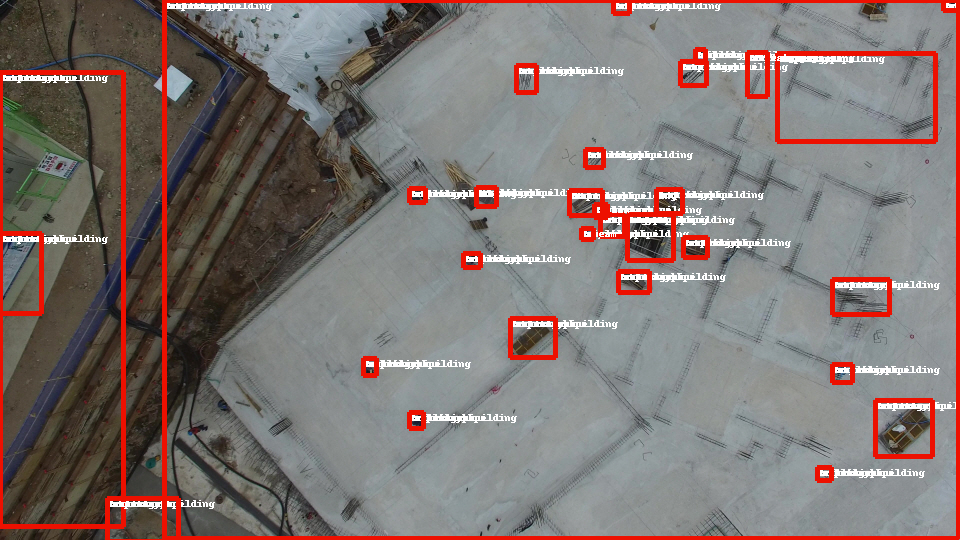

In [245]:
image

In [297]:
stop_model(model_arn=prj_version_arn, client=reko)

Stopping model:arn:aws:rekognition:us-east-1:113147044314:project/construction-object-recognition/version/construction-object-recognition.2020-02-27T14.54.41/1582811681651
Status: STOPPING
Done...
